In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10

legend_opts = {
    'fontsize': 15,
    'frameon': True,
    'framealpha': 1,
    'facecolor': 'white',
    'edgecolor': 'black',
    'labelspacing': 0.1}

%matplotlib inline

## Calculate p-value of a given samples

In [4]:
sample_df = pd.read_csv('../data/sample.csv')
sample_df

,group,song_start
0,new_sample,18
1,new_sample,19
2,new_sample,10
3,new_sample,37
4,control_sample,17
...,...,...
195,new_sample,6
196,control_sample,1
197,new_sample,8
198,new_sample,6


In [5]:
control_sample = sample_df.loc[sample_df['group']=='control_sample', 'song_start'].values
new_sample = sample_df.loc[sample_df['group']=='new_sample', 'song_start'].values

[Levene's test](https://en.wikipedia.org/wiki/Levene%27s_test) to check if two groups have the equal variance

**p-value > 0.05**: no strong evidence to reject that two groups have equal variance

In [6]:
stats.levene(control_sample, new_sample)

LeveneResult(statistic=2.7584559400667485, pvalue=0.09832423236171067)

In [7]:
# Compute mean, standard deviation, and sample size of control & new sample
control_sample_mean, new_sample_mean = control_sample.mean(), new_sample.mean()
control_sample_std, new_sample_std = control_sample.std(), new_sample.std()
control_sample_size, new_sample_size = len(control_sample), len(new_sample)

# Calculate t-value for each pairs of sample
mean_diff_sample = new_sample_mean - control_sample_mean
mean_diff_sample

3.2299999999999986

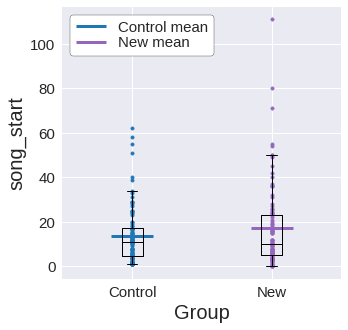

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter([0]*len(control_sample), control_sample, marker='.', color='tab:blue')
plt.scatter([1]*len(new_sample), new_sample, marker='.', color='tab:purple')

plt.boxplot([control_sample, new_sample], showfliers=False, zorder=11, medianprops={'color': 'black'}, positions=[0, 1])
plt.hlines(control_sample_mean, -0.15, 0.15, linewidth=3, color='tab:blue', label='Control mean')
plt.hlines(new_sample_mean, 0.85, 1.15, linewidth=3, color='tab:purple', label='New mean')
plt.legend(**legend_opts)

plt.xticks([0, 1], ['Control', 'New'])
plt.xlabel('Group')
plt.ylabel('song_start')

plt.show()

In [9]:
pooled_variance = ((control_sample_size - 1)*control_sample_std**2 + (new_sample_size-1)*new_sample_std**2) / (control_sample_size + new_sample_size - 2)
standard_error = np.sqrt(pooled_variance/control_sample_size + pooled_variance/new_sample_size)
t_value_sample = mean_diff_sample / standard_error
t_value_sample

1.4409344097745855

**p-value > 0.05**: not enough evidence to reject null hypothesis (two groups have the same song_start on average)

In [10]:
p_value = 2 * (1 - scipy.stats.t.cdf(t_value_sample, df=control_sample_size + new_sample_size - 2))
p_value

0.1511827428896404

## Visualize population data under null hypothesis

In [11]:
df = pd.read_csv('../data/population_null.csv')
df.head(100)

,group,song_start
0,control_pop,26
1,control_pop,10
2,control_pop,16
3,control_pop,5
4,new_pop,10
...,...,...
95,new_pop,7
96,new_pop,4
97,control_pop,2
98,control_pop,10


In [12]:
control_pop = df.loc[df['group']=='control_pop', 'song_start'].values
new_pop = df.loc[df['group']=='new_pop', 'song_start'].values

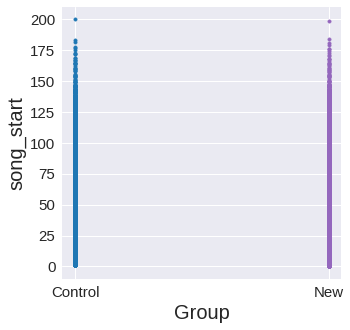

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter([0]*len(control_pop), control_pop, marker='.', color='tab:blue')
plt.scatter([1]*len(new_pop), new_pop, marker='.', color='tab:purple')
plt.xticks([0, 1], ['Control', 'New'])
plt.xlabel('Group')
plt.ylabel('song_start')

plt.show()

Plot histogram of both populations

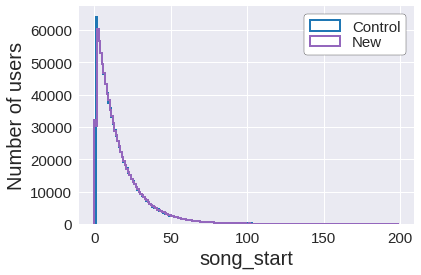

In [14]:
plt.hist(control_pop, bins=np.arange(0, 200), histtype='step', color='tab:blue', linewidth=2, label='Control')
plt.hist(new_pop, bins=np.arange(0, 200), histtype='step', color='tab:purple', linewidth=2, label='New')
plt.xlabel('song_start')
plt.ylabel('Number of users')

plt.legend(**legend_opts)
plt.show()

## Sampling from both populations

In [15]:
rng = np.random.RandomState(seed=42)
sample_size = 100
t_values = []
control_sample_means = []
new_sample_means = []
mean_diffs = []

for i in range(500):
    control_sample = rng.choice(control_pop, size=sample_size, replace=False)
    new_sample = rng.choice(new_pop, size=sample_size, replace=False)
    
    # Compute mean, standard deviation, and sample size of control & new sample
    control_sample_mean, new_sample_mean = control_sample.mean(), new_sample.mean()
    control_sample_std, new_sample_std = control_sample.std(), new_sample.std()
    control_sample_size, new_sample_size = len(control_sample), len(new_sample)
    
    # Calculate t-value for each pairs of sample
    mean_diff = new_sample_mean - control_sample_mean
    pooled_variance = ((control_sample_size - 1)*control_sample_std**2 + (new_sample_size-1)*new_sample_std**2) / (control_sample_size + new_sample_size - 2)
    standard_error = np.sqrt(pooled_variance/control_sample_size + pooled_variance/new_sample_size)
    t_value = mean_diff / standard_error
    
    # Track values after each simulation
    control_sample_means.append(control_sample_mean)
    new_sample_means.append(new_sample_mean)
    mean_diffs.append(mean_diff)
    t_values.append(t_value)

Histogram of sample mean distributions demonstrates effect of [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)

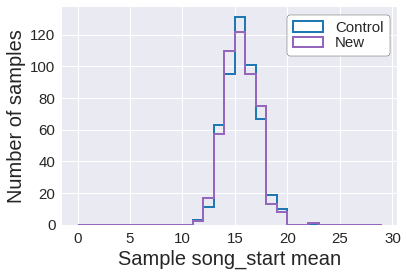

In [16]:
plt.hist(control_sample_means, bins=np.arange(0, 30), histtype='step', color='tab:blue', linewidth=2, label='Control')
plt.hist(new_sample_means, bins=np.arange(0, 30), histtype='step', color='tab:purple', linewidth=2, label='New')
plt.xlabel('Sample song_start mean')
plt.ylabel('Number of samples')

plt.legend(**legend_opts)

plt.show()

[QQ plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) of sample mean distributions

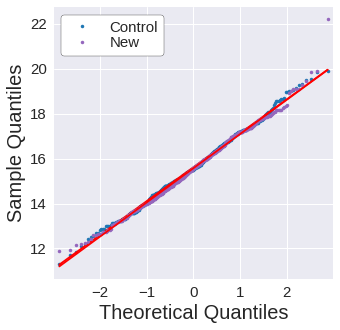

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
qqplot(np.array(control_sample_means), marker='.', color='tab:blue', line='s', ax=ax, label='Control')
qqplot(np.array(new_sample_means), marker='.', color='tab:purple', line='s', ax=ax, label='New')

ax.legend(**legend_opts)
plt.show()

Histogram of differences in sample means

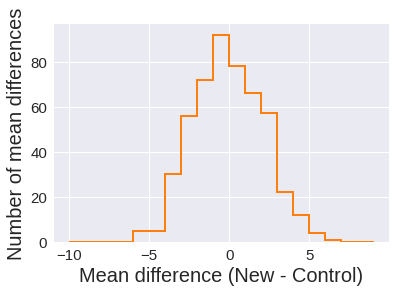

In [18]:
plt.hist(mean_diffs, bins=np.arange(-10, 10), histtype='step', color='tab:orange', linewidth=2)
plt.xlabel('Mean difference (New - Control)')
plt.ylabel('Number of mean differences')

plt.show()

Histogram of t-values

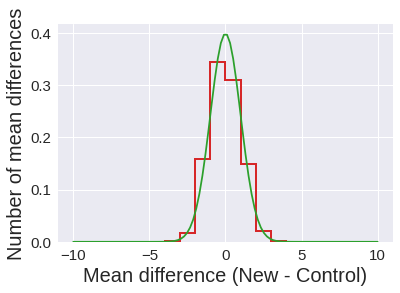

In [19]:
plt.hist(t_values, bins=np.arange(-10, 10), histtype='step', color='tab:red', linewidth=2, density=True)
plt.xlabel('Mean difference (New - Control)')
plt.ylabel('Number of mean differences')

df = int(sample_size + sample_size - 2)

ts = np.linspace(-10, 10, 100)
t_pdfs = scipy.stats.t.pdf(ts, df=df)
plt.plot(ts, t_pdfs, color='tab:green')

plt.show()

### Plot t-value of sample in t-distribution

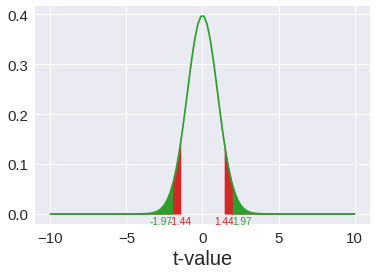

In [20]:
ts = np.linspace(-10, 10, 100)
t_pdfs = scipy.stats.t.pdf(ts, df=df)
plt.plot(ts, t_pdfs, color='tab:green')

left_t = scipy.stats.t.ppf(0.025, df=df)
right_t = -left_t

left_ts = np.linspace(-10, left_t, 50)
right_ts = np.linspace(right_t, 10, 50)

sample_left_ts = np.linspace(-10, -t_value_sample, 50)
sample_right_ts = np.linspace(t_value_sample, 10, 50)

plt.fill_between(sample_left_ts, scipy.stats.t.pdf(sample_left_ts, df=df), color='tab:red')
plt.fill_between(sample_right_ts, scipy.stats.t.pdf(sample_right_ts, df=df), color='tab:red')

plt.fill_between(left_ts, scipy.stats.t.pdf(left_ts, df=df), color='tab:green')
plt.fill_between(right_ts, scipy.stats.t.pdf(right_ts, df=df), color='tab:green')

plt.text(t_value_sample, -0.02, round(t_value_sample, 2), ha='center', color='tab:red')
plt.text(-t_value_sample, -0.02, round(-t_value_sample, 2), ha='center', color='tab:red')

plt.text(left_t, -0.02, round(left_t, 2), ha='right', color='tab:green')
plt.text(-left_t, -0.02, round(-left_t, 2), ha='left', color='tab:green')

plt.xlabel('t-value')
plt.show()

# Does that mean there's no difference between 2 groups?

Not really. In fact there might indeed be a difference of 3.23, but we just **do not have enough sample size** (users) to observe this difference with confidence.

### Plot distribution of sample means, mean difference, and t-value if real difference = 3.23 and sample size = 100

In [21]:
df = pd.read_csv('../data/population_alternative.csv')

In [22]:
control_pop = df.loc[df['group']=='control_pop', 'song_start'].values
new_pop = df.loc[df['group']=='new_pop', 'song_start'].values

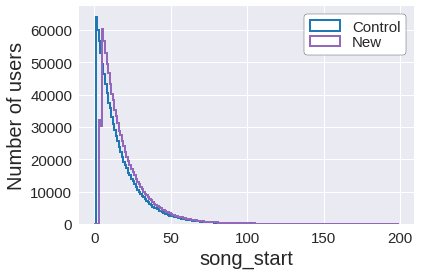

In [23]:
plt.hist(control_pop, bins=np.arange(0, 200), histtype='step', color='tab:blue', linewidth=2, label='Control')
plt.hist(new_pop, bins=np.arange(0, 200), histtype='step', color='tab:purple', linewidth=2, label='New')
plt.xlabel('song_start')
plt.ylabel('Number of users')

plt.legend(**legend_opts)
plt.show()

In [24]:
rng = np.random.RandomState(seed=42)
sample_size = 100
t_values = []
control_sample_means = []
new_sample_means = []
mean_diffs = []

for i in range(500):
    control_sample = rng.choice(control_pop, size=sample_size, replace=False)
    new_sample = rng.choice(new_pop, size=sample_size, replace=False)
    
    # Compute mean, standard deviation, and sample size of control & new sample
    control_sample_mean, new_sample_mean = control_sample.mean(), new_sample.mean()
    control_sample_std, new_sample_std = control_sample.std(), new_sample.std()
    control_sample_size, new_sample_size = len(control_sample), len(new_sample)
    
    # Calculate t-value for each pairs of sample
    mean_diff = new_sample_mean - control_sample_mean
    pooled_variance = ((control_sample_size - 1)*control_sample_std**2 + (new_sample_size-1)*new_sample_std**2) / (control_sample_size + new_sample_size - 2)
    standard_error = np.sqrt(pooled_variance/control_sample_size + pooled_variance/new_sample_size)
    t_value = mean_diff / standard_error
    
    # Track values after each simulation
    control_sample_means.append(control_sample_mean)
    new_sample_means.append(new_sample_mean)
    mean_diffs.append(mean_diff)
    t_values.append(t_value)

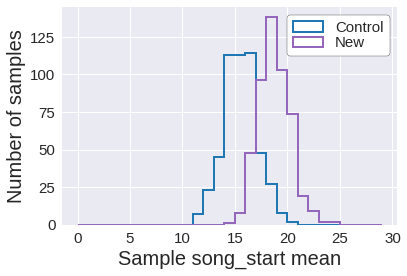

In [25]:
plt.hist(control_sample_means, bins=np.arange(0, 30), histtype='step', color='tab:blue', linewidth=2, label='Control')
plt.hist(new_sample_means, bins=np.arange(0, 30), histtype='step', color='tab:purple', linewidth=2, label='New')
plt.xlabel('Sample song_start mean')
plt.ylabel('Number of samples')

plt.legend(**legend_opts)

plt.show()

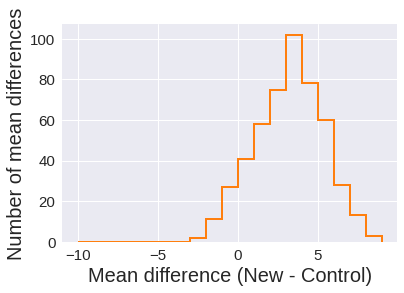

In [26]:
plt.hist(mean_diffs, bins=np.arange(-10, 10), histtype='step', color='tab:orange', linewidth=2)
plt.xlabel('Mean difference (New - Control)')
plt.ylabel('Number of mean differences')

plt.show()

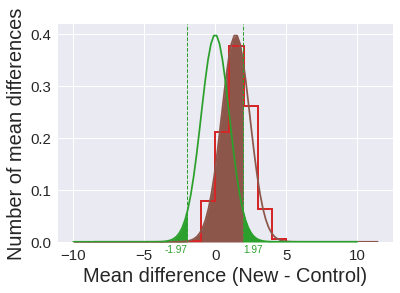

In [27]:
plt.hist(t_values, bins=np.arange(-10, 10), histtype='step', color='tab:red', linewidth=2, density=True)
plt.xlabel('Mean difference (New - Control)')
plt.ylabel('Number of mean differences')

df = int(sample_size + sample_size - 2)

ts = np.linspace(-10, 10, 100)
t_pdfs = scipy.stats.t.pdf(ts, df=df)
plt.plot(ts + t_value_sample, t_pdfs, color='tab:brown')
plt.plot(ts, t_pdfs, color='tab:green')

left_t = scipy.stats.t.ppf(0.025, df=df)
left_ts = np.linspace(-10, left_t, 50)
right_ts = np.linspace(-left_t, 10, 50)

plt.fill_between(left_ts, scipy.stats.t.pdf(left_ts, df=df), color='tab:green')
plt.fill_between(right_ts, scipy.stats.t.pdf(right_ts, df=df), color='tab:green')

plt.axvline(-left_t, ls='--', lw=1, color='tab:green')
plt.axvline(left_t, ls='--', lw=1, color='tab:green')

ts_under_alternative = np.linspace(-10, -left_t, 50)
plt.fill_between(ts_under_alternative, scipy.stats.t.pdf(ts_under_alternative - t_value_sample, df=df), color='tab:brown')

plt.text(left_t, -0.02, round(left_t, 2), ha='right', color='tab:green')
plt.text(-left_t, -0.02, round(-left_t, 2), ha='left', color='tab:green')

plt.show()

If the true difference is indeed 3.23, we fail to detect it 70% of the time with a sample size of 100!

In [28]:
scipy.stats.t.cdf(-left_t - t_value_sample, df=df)

0.7020217763700316

## Required sample size

In [29]:
sample_df = pd.read_csv('../data/sample.csv')
sample_df

,group,song_start
0,new_sample,18
1,new_sample,19
2,new_sample,10
3,new_sample,37
4,control_sample,17
...,...,...
195,new_sample,6
196,control_sample,1
197,new_sample,8
198,new_sample,6


In [30]:
control_sample = sample_df.loc[sample_df['group']=='control_sample', 'song_start'].values

In [31]:
n_required = ceil(2 * (scipy.stats.norm.ppf(0.025) + scipy.stats.norm.ppf(0.2))**2 * control_sample.std()**2 / mean_diff_sample**2)
n_required

244

### Plot distribution of sample means, mean difference, and t-value if true difference = 3.23 and enough sample is collected

In [32]:
rng = np.random.RandomState(seed=42)
sample_size = n_required
t_values = []
control_sample_means = []
new_sample_means = []
mean_diffs = []

for i in range(500):
    control_sample = rng.choice(control_pop, size=sample_size, replace=False)
    new_sample = rng.choice(new_pop, size=sample_size, replace=False)
    
    # Compute mean, standard deviation, and sample size of control & new sample
    control_sample_mean, new_sample_mean = control_sample.mean(), new_sample.mean()
    control_sample_std, new_sample_std = control_sample.std(), new_sample.std()
    control_sample_size, new_sample_size = len(control_sample), len(new_sample)
    
    # Calculate t-value for each pairs of sample
    mean_diff = new_sample_mean - control_sample_mean
    pooled_variance = ((control_sample_size - 1)*control_sample_std**2 + (new_sample_size-1)*new_sample_std**2) / (control_sample_size + new_sample_size - 2)
    standard_error = np.sqrt(pooled_variance/control_sample_size + pooled_variance/new_sample_size)
    t_value = mean_diff / standard_error
    
    # Track values after each simulation
    control_sample_means.append(control_sample_mean)
    new_sample_means.append(new_sample_mean)
    mean_diffs.append(mean_diff)
    t_values.append(t_value)

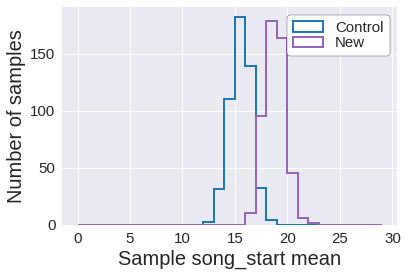

In [33]:
plt.hist(control_sample_means, bins=np.arange(0, 30), histtype='step', color='tab:blue', linewidth=2, label='Control')
plt.hist(new_sample_means, bins=np.arange(0, 30), histtype='step', color='tab:purple', linewidth=2, label='New')
plt.xlabel('Sample song_start mean')
plt.ylabel('Number of samples')

plt.legend(**legend_opts)

plt.show()

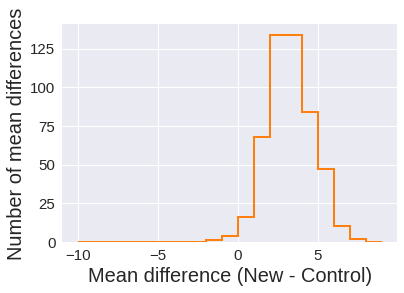

In [34]:
plt.hist(mean_diffs, bins=np.arange(-10, 10), histtype='step', color='tab:orange', linewidth=2)
plt.xlabel('Mean difference (New - Control)')
plt.ylabel('Number of mean differences')

plt.show()

We are able to detect a real difference of 3.23 at around 80% when enough samples are collected (244 users/group)

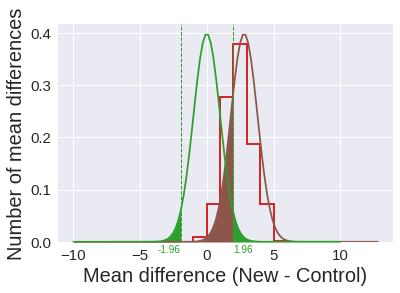

In [35]:
plt.hist(t_values, bins=np.arange(-10, 10), histtype='step', color='tab:red', linewidth=2, density=True)
plt.xlabel('Mean difference (New - Control)')
plt.ylabel('Number of mean differences')

df = int(sample_size + sample_size - 2)

ts = np.linspace(-10, 10, 100)
t_pdfs = scipy.stats.t.pdf(ts, df=df)
plt.plot(ts + 2.80, t_pdfs, color='tab:brown')
plt.plot(ts, t_pdfs, color='tab:green')

left_t = scipy.stats.t.ppf(0.025, df=df)
left_ts = np.linspace(-10, left_t, 50)
right_ts = np.linspace(-left_t, 10, 50)

plt.fill_between(left_ts, scipy.stats.t.pdf(left_ts, df=df), color='tab:green')
plt.fill_between(right_ts, scipy.stats.t.pdf(right_ts, df=df), color='tab:green')

plt.axvline(-left_t, ls='--', lw=1, color='tab:green')
plt.axvline(left_t, ls='--', lw=1, color='tab:green')

ts_under_alternative = np.linspace(-10, -left_t, 50)
plt.fill_between(ts_under_alternative, scipy.stats.t.pdf(ts_under_alternative - 2.80, df=df), color='tab:brown')

plt.text(left_t, -0.02, round(left_t, 2), ha='right', color='tab:green')
plt.text(-left_t, -0.02, round(-left_t, 2), ha='left', color='tab:green')

plt.show()